In [36]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from ta.momentum import RSIIndicator

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
#from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn import tree


### Data Management

In [2]:
# Data Extraction
symbol = "TATAMOTORS.NS"

df = pd.read_csv("../stock_historical_data/{}.csv".format(symbol))
df.set_index("Date", inplace=True)


In [3]:
df.describe()

,Open,High,Low,Close,Volume
count,892.000000,892.000000,892.000000,892.000000,8.920000e+02
mean,334.666449,339.496231,329.334522,334.187235,4.105141e+07
std,149.662591,150.887877,148.079047,149.434955,4.062217e+07
min,66.293381,66.692142,63.302708,65.097115,0.000000e+00
25%,183.403383,185.721156,179.789643,182.693100,1.430685e+07
50%,385.473601,389.137180,376.102793,382.682297,2.756312e+07
75%,444.140742,449.399332,438.732612,444.103363,5.525996e+07
max,646.000000,663.332642,642.000000,644.299988,3.905778e+08


In [4]:
df["Returns"] = df["Close"].pct_change()
df["RSI"] =  RSIIndicator(close=df["Close"], window=14).rsi()
df["Range"] = df["High"] / df["Low"] - 1
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_200"] = df["Close"].rolling(window=200).mean()
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df[""]
df.dropna(inplace=True)

In [5]:
# Specify Target
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1
df.loc[df["Close"].shift(-1) <= df["Close"], "TARGET"] = 0

In [6]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,RSI,Range,MA_50,MA_20,MA_200,Avg_Range,TARGET
Date,,,,,,,,,,,,,
2023-07-27,644.989747,646.435254,634.771594,641.700012,11696851.0,0.004056,74.551979,0.018375,574.757653,615.646219,465.389025,0.020203,0.0
2023-07-28,646.000000,646.000000,631.799988,635.299988,9299530.0,-0.009974,68.617054,0.022475,577.326248,617.726239,466.511177,0.020527,1.0
2023-07-31,640.200012,645.549988,635.900024,644.299988,7498265.0,0.014167,71.993505,0.015175,579.745868,620.493021,467.759078,0.020671,0.0
2023-07-31,645.000000,652.900024,642.000000,643.650024,8922021.0,-0.001009,71.396095,0.016978,582.201337,623.194904,469.016689,0.020705,0.0
2023-08-01,644.000000,644.299988,616.450012,622.650024,15757048.0,-0.032626,55.400293,0.045178,584.117178,625.006290,470.153350,0.020940,0.0


In [7]:
df.describe()

,Open,High,Low,Close,Volume,Returns,RSI,Range,MA_50,MA_20,MA_200,Avg_Range,TARGET
count,693.000000,693.000000,693.000000,693.000000,6.930000e+02,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,395.895589,401.344469,389.914371,395.411541,3.373807e+07,0.002617,55.158816,0.030717,378.806978,388.597716,339.180082,0.031184,0.551227
std,107.786811,108.380519,106.676768,107.417074,3.909990e+07,0.025718,12.949607,0.018956,105.255890,106.504440,116.430063,0.009683,0.497728
min,127.702005,129.895167,125.957435,127.851524,0.000000e+00,-0.102830,23.031074,0.000000,135.253456,132.357481,115.528682,0.018395,0.000000
25%,316.064905,322.843812,311.130311,316.563354,1.248894e+07,-0.010692,45.883678,0.018671,310.379642,311.987636,245.628949,0.023758,0.000000
50%,418.645214,422.682614,412.314945,416.850800,1.976672e+07,0.002223,53.962433,0.025319,416.458030,418.797235,402.324080,0.027863,1.000000
75%,466.396405,472.477443,458.720303,466.795135,3.926740e+07,0.013415,65.145159,0.036333,447.654795,458.844920,433.157481,0.037532,1.000000
max,646.000000,663.332642,642.000000,644.299988,3.905778e+08,0.204467,91.791636,0.149920,584.117178,625.006290,470.153350,0.062478,1.000000


### Train Test Split

In [8]:
# Feature Selection
df_tts = df.copy()
#df_tts = df_tts[[ "Range", "RSI", "RSI_Ret", "Avg_Range", "RSI_Ret_T1", "TARGET"]]

In [9]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [10]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (485, 12)
Shape of y_train:  (485,)
Shape of X_test:  (208, 12)
Shape of y_test:  (208,)
Size Matches:  True


### Build Model

In [11]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [12]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [13]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [14]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
# ne: 1#15, lr: 0.2 md: 5 gm: 20
#Recommended Params >> ne: 65, lr: 0.05 md: 1 gm: 20

ne = 65
lr = 0.05
md = 1
gm = 20

In [15]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [16]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Make Predictions

In [17]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [1 1 1 1 1 1 1 1 1 1]
Preds Probabilities Training Data: 
 [[0.44031203 0.559688  ]
 [0.44031203 0.559688  ]
 [0.44031203 0.559688  ]]


In [18]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [1 1 1 1 1 1 1 1 1 1]
Preds Probabilities Training Data: 
 [[0.44031203 0.559688  ]
 [0.44031203 0.559688  ]
 [0.44031203 0.559688  ]]


In [19]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [20]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

### Evaluation Metrics  - Loss and Overfitting

In [21]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

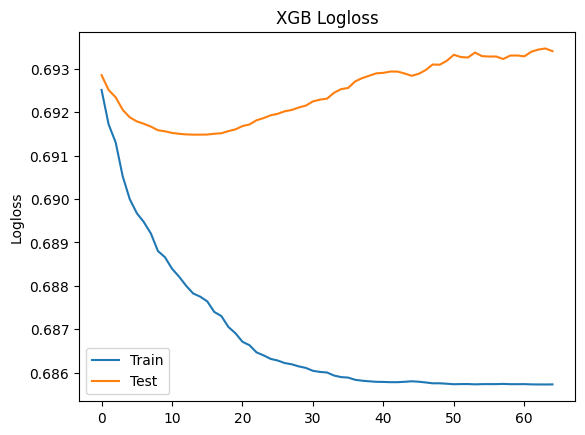

In [22]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

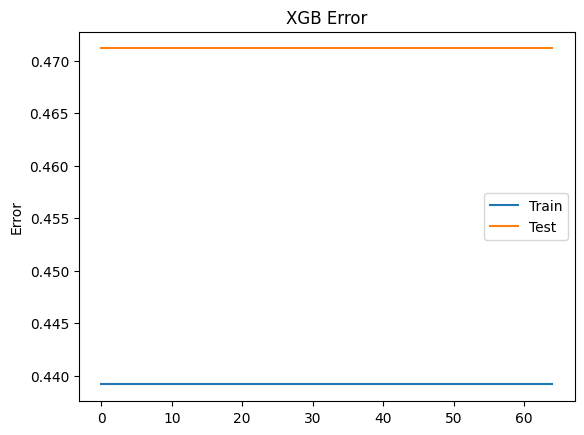

In [23]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

In [24]:
# Plot Training ROC Curve
#plot_roc_curve(classifier, X_train, y_train)

In [25]:
# Plot Test ROC Curve
#plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [26]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [27]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [28]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.56
Std Dev K-Fold 0.01
Precision Score 0 0.0
Precision Score 1 0.561
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.53
Std Dev K-Fold 0.01
Precision Score 0 0.0
Precision Score 1 0.529



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaco

### Evaluation Metrics - Summary Report

In [29]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       213
         1.0       0.56      1.00      0.72       272

    accuracy                           0.56       485
   macro avg       0.28      0.50      0.36       485
weighted avg       0.31      0.56      0.40       485



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [30]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        98
         1.0       0.53      1.00      0.69       110

    accuracy                           0.53       208
   macro avg       0.26      0.50      0.35       208
weighted avg       0.28      0.53      0.37       208



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

### Performance Evaluation - Confusion Matrix

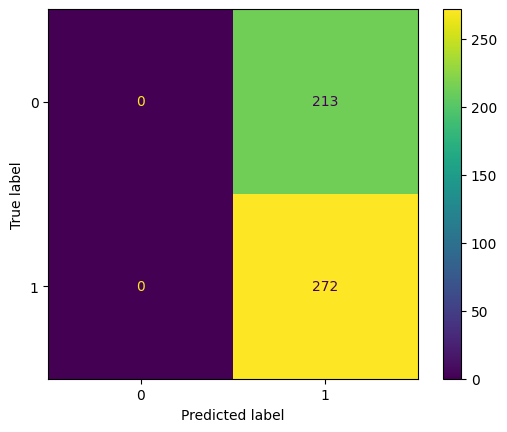

In [31]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

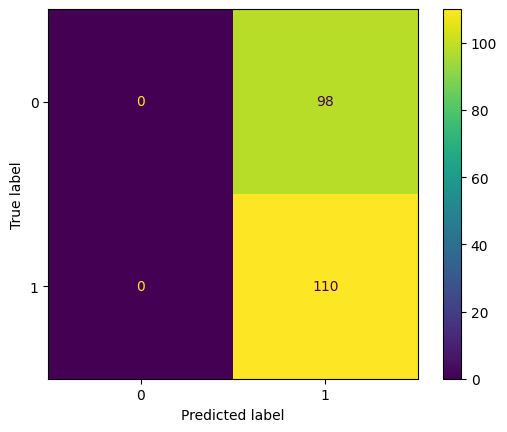

In [32]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

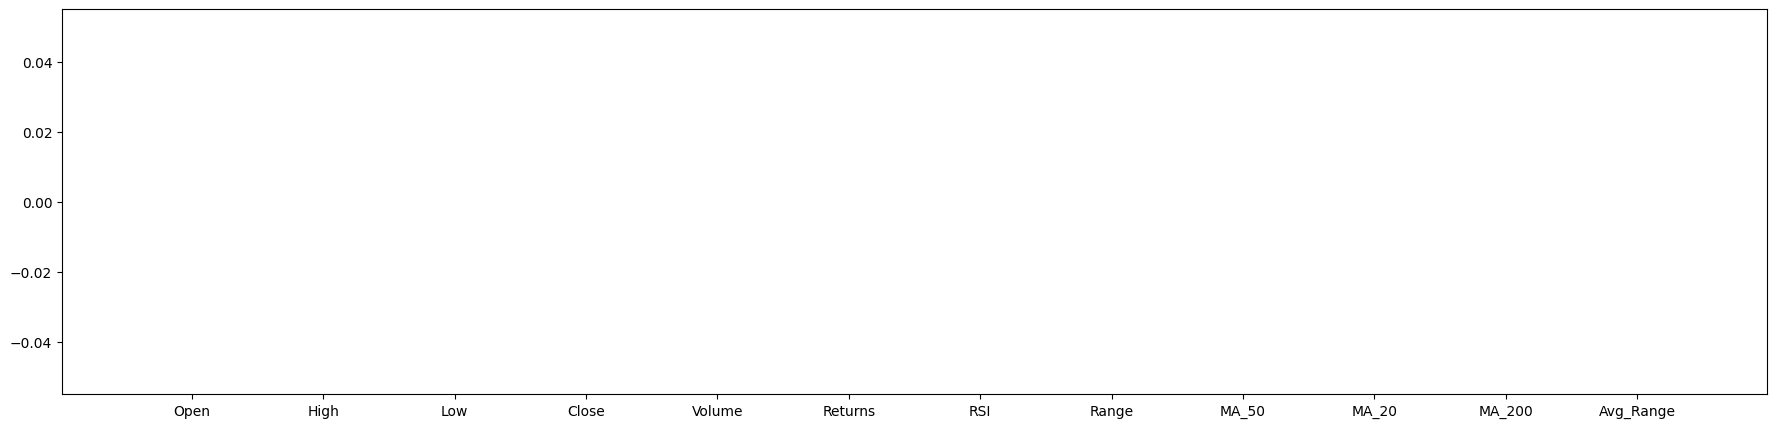

In [33]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [34]:
#conda install graphviz python-graphviz

### XGBOOST TREE

In [38]:
rcParams["figure.figsize"] = 80, 50
tree.plot_tree(classifier)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...) instead.

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.